## LightGBM  classifier

In [1]:
import numpy as np
import pandas as pd

### Text preprocessing

In [2]:
df_selected = pd.read_csv('data/rusentiment/rusentiment_preselected_posts.csv')
df_random = pd.read_csv('data/rusentiment/rusentiment_random_posts.csv')
df_test = pd.read_csv('data/rusentiment/rusentiment_test.csv')

In [3]:
df_train = pd.concat((df_selected, df_random))#available other ways to concatenate
df_train.reset_index(inplace=True, drop=True)

In [4]:
from ufal.udpipe import Model, Pipeline

In [5]:
# Original code https://github.com/akutuzov/webvectors/blob/master/preprocessing/rus_preprocessing_udpipe.py

def tag_ud(pipeline, text='Text in string format', pos=True):
    # если частеречные тэги не нужны (например, их нет в модели), выставьте pos=False
    # в этом случае на выход будут поданы только леммы

    # обрабатываем текст, получаем результат в формате conllu:
    processed = pipeline.process(text)

    # пропускаем строки со служебной информацией:
    content = [l for l in processed.split('\n') if not l.startswith('#')]

    # извлекаем из обработанного текста лемму и тэг
    tagged = [w.split('\t')[2].lower() + '_' + w.split('\t')[3] for w in content if w]
    result = []
    for t in tagged:
        if (len(t.split('_')) == 2):
            lemma, tag = t.split('_')
            # убираем числительные и все знаки пунктуации кроме скобок
            if tag == 'NUM' or (tag == 'PUNCT' and lemma not in ['(', ')']):
                continue
            if pos:
                result.append(lemma + '_' + tag)
            else:
                result.append(lemma)
    return result

In [6]:
#! wget http://rusvectores.org/static/models/udpipe_syntagrus.model
udpipe_filename = 'udpipe_syntagrus.model'
model = Model.load(udpipe_filename)
process_pipeline = Pipeline(model, 'tokenize', Pipeline.DEFAULT, Pipeline.DEFAULT, 'conllu')

In [7]:
df_train['lemmatized_tokens'] = df_train.apply(lambda x: tag_ud(process_pipeline, x['text'], pos=False), axis=1)
df_test['lemmatized_tokens'] = df_test.apply(lambda x: tag_ud(process_pipeline, x['text'], pos=False), axis=1)

### Encoding labels of classes

In [9]:
from sklearn import preprocessing

In [10]:
le = preprocessing.LabelEncoder()

In [14]:
df_train['lemmatized_text'] = df_train['lemmatized_tokens'].str.join(' ')
df_test['lemmatized_text'] = df_test['lemmatized_tokens'].str.join(' ')

In [15]:
X_train = df_train['lemmatized_text'].values
X_test = df_test['lemmatized_text'].values

Y_train = le.fit_transform(df_train['label'].values)
Y_test = le.transform(df_test['label'].values)

### Using TfidfVectorizer

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,1), sublinear_tf=False)
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

### Learning model

In [21]:
#functions for fast model scoring
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

def score_model(y_pred, y_true):
    average = 'weighted'
    f1 = f1_score(y_true, y_pred, average=average)
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    return f1, precision, recall

def check_model(y_pred,Y_test):
    f1, precision, recall = score_model(y_pred,Y_test)
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'f1-score: {f1:.4f}')


In [46]:
import lightgbm as lgb
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import StratifiedKFold

In [142]:
# X_train_split, X_valid, Y_train_split, Y_valid= train_test_split(X_train_vect, Y_train, test_size=0.33, shuffle=True)
# dataset_train = lgb.Dataset(X_train_split, label = Y_train_split)
# dataset_valid = lgb.Dataset(X_valid, label = Y_valid)

In [47]:
k = 5
skf = StratifiedKFold(n_splits=k, random_state=42)

In [68]:
lgbm_pipeline = Pipeline([
    ('lgbm', lgb.LGBMClassifier() )
])


param_grid = {
    'lgbm__learning_rate':[0.1, 0.05, 0.01],
    'lgbm__n_estimators':[100,200,250],
    'lgbm__max_depth':[3,5,10]
}

grid = GridSearchCV(estimator=gbc_pipeline,scoring='f1_macro', param_grid=param_grid, cv=skf)

In [69]:
grid_model = grid.fit(X_train_vect,Y_train)

In [71]:
grid_model.best_params_

{'lgbm__learning_rate': 0.1, 'lgbm__max_depth': 10, 'lgbm__n_estimators': 250}

In [72]:
Y_pred = grid_model.predict(X_test_vect)

In [73]:
check_model(Y_pred,Y_test)

Precision: 0.6365
Recall: 0.6542
f1-score: 0.6136


In [70]:
#{'lgbm__learning_rate': 0.1, 'lgbm__max_depth': 5, 'lgbm__n_estimators': 250}
# Precision: 0.6397
# Recall: 0.6461
# f1-score: 0.5967

### Confusion matrix

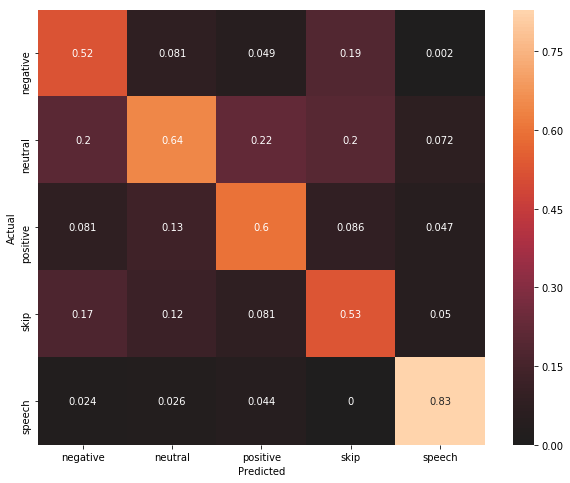

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(Y_test, Y_pred)
conf_mat_ratios = np.round(conf_mat / np.sum(conf_mat, axis=0),3)
fig, ax = plt.subplots(figsize=(10,8))

labels = sorted(list(set(le.inverse_transform(Y_pred))))
sns.heatmap(conf_mat_ratios, annot=True, center=0, xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Errors observing

In [75]:
y_pred_labels = le.inverse_transform(Y_pred)
y_test_labels = le.inverse_transform(Y_test)

results = pd.DataFrame({'text':df_test.text, 'lemmatized_tokens':df_test.lemmatized_tokens,'predicted':y_pred_labels, 'actual':y_test_labels})
errors = results[results.predicted != results.actual]

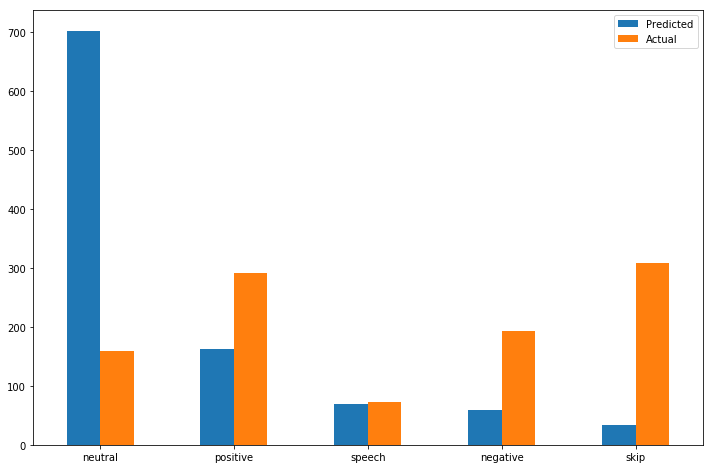

In [76]:
fig, ax = plt.subplots(figsize=(12, 8))
freq = pd.DataFrame({'Predicted': errors.predicted.value_counts(), 'Actual':errors.actual.value_counts()})
freq.sort_values(by='Predicted', ascending=False).plot.bar(rot=0, ax=ax);

In [77]:
errors

,text,lemmatized_tokens,predicted,actual
3,Мы просто с [id12210212|Елисеем] психанули )...,"[мы, просто, с, id12210212|елисей, психануть, ...",positive,skip
8,"нельзя общаться с людьми, которые нуждаются в ...","[нельзя, общаться, с, человек, который, нуждат...",neutral,negative
11,Селфи дня )),"[селфи, день, ), )]",neutral,positive
15,"Ураааа, нам сегодня три годика.....😊","[ураааа, мы, сегодня, гектодикар, 😊]",neutral,positive
17,"Я не писал такое оскобление всем!!!!\nМеня, ви...","[я, не, писать, такой, оскоблений, все, я, вид...",neutral,skip
18,...и так начало мини отпуска))И новых приключе...,"[...ь, так, начинать, минять, отпуск, ), ), и,...",neutral,positive
19,Кинул в чс обиделся холоп понял что недостоин ...,"[кидать, в, чс, обижаться, холоп, понимать, чт...",neutral,negative
21,Лучше бы у Тани не было никакого оргазма: услы...,"[хороший, бы, в, таня, не, быть, никакой, орга...",neutral,skip
22,"Аю,слова правильные,но такие унылые(((Сьешь ко...","[аю,слов, правильный, ,но, такой, унылый, (, (...",positive,negative
23,и тебе няшку),"[и, ты, няшка, )]",neutral,positive


### Default gradient-boosting classifier

In [154]:
default_lgbc = lgb.LGBMClassifier()

#### Fitting with validation set

In [180]:
default_lgbc.fit(X = X_train_split, y = Y_train_split, eval_set=[(X_valid,Y_valid)]);

[1]	valid_0's multi_logloss: 1.56036
[2]	valid_0's multi_logloss: 1.5197
[3]	valid_0's multi_logloss: 1.48501
[4]	valid_0's multi_logloss: 1.4553
[5]	valid_0's multi_logloss: 1.42921
[6]	valid_0's multi_logloss: 1.4064
[7]	valid_0's multi_logloss: 1.38647
[8]	valid_0's multi_logloss: 1.36835
[9]	valid_0's multi_logloss: 1.35248
[10]	valid_0's multi_logloss: 1.33785
[11]	valid_0's multi_logloss: 1.32524
[12]	valid_0's multi_logloss: 1.31393
[13]	valid_0's multi_logloss: 1.30379
[14]	valid_0's multi_logloss: 1.29416
[15]	valid_0's multi_logloss: 1.28528
[16]	valid_0's multi_logloss: 1.27744
[17]	valid_0's multi_logloss: 1.26994
[18]	valid_0's multi_logloss: 1.26333
[19]	valid_0's multi_logloss: 1.25698
[20]	valid_0's multi_logloss: 1.25123
[21]	valid_0's multi_logloss: 1.24566
[22]	valid_0's multi_logloss: 1.24062
[23]	valid_0's multi_logloss: 1.23574
[24]	valid_0's multi_logloss: 1.23159
[25]	valid_0's multi_logloss: 1.22725
[26]	valid_0's multi_logloss: 1.22349
[27]	valid_0's multi_log

In [183]:
check_model(default_lgbc.predict(X_test_vect), Y_test)

Precision: 0.6238
Recall: 0.6380
f1-score: 0.5929


#### Fitting without validation set

In [185]:
default_lgbc.fit(X = X_train_vect, y = Y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [186]:
check_model(default_lgbc.predict(X_test_vect),Y_test)

Precision: 0.6314
Recall: 0.6481
f1-score: 0.6082


### Parameters tuning

In [ ]:
#learning rate (default = 0.1) - small with large num_iterations
#n_estimators (default =100) - large


In [189]:
from  sklearn.model_selection import GridSearchCV

In [191]:
param_grid = {'learning_rate':[0.1, 0.05, 0.01],
              'n_estimators':[100,200,300]}

In [201]:
grid = GridSearchCV(estimator=default_lgbc, param_grid = param_grid )

In [ ]:
#grid = RandomizedSearchCV(svc_pipeline, param_grid, n_iter=10, scoring='f1_macro', cv=skf, n_jobs=-1)

In [205]:
grid_model = grid.fit(X = X_train_vect, y = Y_train)

/home/friday/anaconda3/envs/boringname/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [206]:
grid_model.best_params_

{'learning_rate': 0.05, 'n_estimators': 200}

In [210]:

check_model(grid_model.predict(X_test_vect),Y_test)

Precision: 0.6253
Recall: 0.6461
f1-score: 0.6049
